In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install nptdms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nptdms: filename=nptdms-1.10.0-py3-none-any.whl size=108456 sha256=331aca02c4d6842787f6aaf5a3fbc02a44496be568de53289e69146f64d38c7a
  Stored in directory: /root/.cache/pip/wheels/1b/4b/17/21e8b03b37ea51ce7ec9f5570cdf0decca93f537d61c06880f
Successfully built nptdms


In [9]:
import os
import shutil

def copy_train_data_from_drive(drive_base_path, local_base_path="/content/train_data", train_folders=8):
    os.makedirs(local_base_path, exist_ok=True)
    copied = []
    skipped = []

    for i in range(1, train_folders + 1):
        src = os.path.join(drive_base_path, f"Train{i}")
        dst = os.path.join(local_base_path, f"Train{i}")
        try:
            if os.path.exists(dst):
                print(f"⚠️ Already exists, skipping: {dst}")
                skipped.append(dst)
                continue
            shutil.copytree(src, dst)
            print(f"✅ Copied: {src} → {dst}")
            copied.append(dst)
        except Exception as e:
            print(f"❌ Failed to copy {src}: {e}")
            continue
    return copied, skipped

# Google Drive의 Train1~Train8을 Colab 로컬로 복사
drive_train_base = "/content/drive/MyDrive"
copy_train_data_from_drive(drive_train_base)

✅ Copied: /content/drive/MyDrive/Train1 → /content/train_data/Train1
✅ Copied: /content/drive/MyDrive/Train2 → /content/train_data/Train2
✅ Copied: /content/drive/MyDrive/Train3 → /content/train_data/Train3
✅ Copied: /content/drive/MyDrive/Train4 → /content/train_data/Train4
✅ Copied: /content/drive/MyDrive/Train5 → /content/train_data/Train5
✅ Copied: /content/drive/MyDrive/Train6 → /content/train_data/Train6
✅ Copied: /content/drive/MyDrive/Train7 → /content/train_data/Train7
✅ Copied: /content/drive/MyDrive/Train8 → /content/train_data/Train8


(['/content/train_data/Train1',
  '/content/train_data/Train2',
  '/content/train_data/Train3',
  '/content/train_data/Train4',
  '/content/train_data/Train5',
  '/content/train_data/Train6',
  '/content/train_data/Train7',
  '/content/train_data/Train8'],
 [])

## CNN+LSTM

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
from scipy.fft import rfft
import pywt
from nptdms import TdmsFile
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split # 데이터 분리 추가 (필요시 사용)


데이터 전처리 파이프라인

In [11]:
# --- 설정값 ---
data_dir = "Train Set"
# 진동 채널만 사용
channels_raw = ['CH1', 'CH2', 'CH3', 'CH4']

window_size = 25600
overlap = 0.5
wavelet = 'db4'
level = 3
top_k = 10 # WPT+FFT에서 상위 k개 주파수 특징
sampling_rate = 25600 # 진동 데이터 샘플링 레이트
step = int(window_size * (1 - overlap))

# --- TDMS 로드 함수 (진동 채널만, 공백 처리 및 단일 그룹 가정) ---
def load_tdms_data(folder_path, target_channels_raw):
    """
    TDMS 파일에서 지정된 채널의 데이터를 로드합니다.
    컬럼명에 공백이 있고, 모든 채널이 단일 그룹(보통 첫 번째 그룹)에 있다고 가정합니다.
    """
    all_data_dict = {ch.strip(): [] for ch in target_channels_raw} # 공백 제거된 채널명으로 딕셔너리 초기화

    tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tdms")])

    for file in tdms_files:
        file_path = os.path.join(folder_path, file)
        try:
            tdms = TdmsFile.read(file_path)
            groups = tdms.groups()

            if not groups:
                print(f"[경고] {file}에 그룹이 없습니다. 스킵합니다.")
                continue

            # 첫 번째 그룹에 모든 채널이 있다고 가정
            main_group = groups[0]
            channels_in_group = {ch.name.strip(): ch for ch in main_group.channels()} # 공백 제거된 채널명으로 맵핑

            data_per_file = {}
            min_len_file = float('inf') # 파일 내 채널들의 최소 길이를 찾기 위함

            for ch_raw in target_channels_raw:
                ch_stripped = ch_raw.strip()
                if ch_stripped in channels_in_group:
                    data = channels_in_group[ch_stripped].data
                    data_per_file[ch_stripped] = data
                    min_len_file = min(min_len_file, len(data))
                else:
                    print(f"[경고] 파일 '{file}'에서 채널 '{ch_raw}'을(를) 찾을 수 없습니다.")
                    data_per_file[ch_stripped] = np.array([]) # 찾을 수 없으면 빈 배열

            if min_len_file == float('inf') or min_len_file == 0:
                print(f"[경고] 파일 '{file}'에서 유효한 데이터가 없습니다. 스킵합니다.")
                continue

            # 파일 내 모든 채널 데이터를 최소 길이에 맞춰 자르고 저장
            for ch_stripped in all_data_dict.keys():
                if ch_stripped in data_per_file and len(data_per_file[ch_stripped]) >= min_len_file:
                    all_data_dict[ch_stripped].append(data_per_file[ch_stripped][:min_len_file])
                else:
                    # 데이터가 없거나 길이가 짧은 경우, 해당 파일의 모든 채널에 대해 0으로 채워진 배열을 추가
                    all_data_dict[ch_stripped].append(np.zeros(min_len_file))


        except Exception as e:
            print(f"[에러] {file} 처리 중 오류 발생: {e}")

    # 파일별로 로드된 데이터를 채널별로 모두 합치기
    concatenated_data = {}
    for ch_stripped, data_list in all_data_dict.items():
        if data_list:
            concatenated_data[ch_stripped] = np.concatenate(data_list, axis=0)
        else:
            concatenated_data[ch_stripped] = np.array([]) # 데이터가 없으면 빈 배열

    return concatenated_data

# --- 슬라이딩 윈도우 함수 (이전과 동일) ---
def sliding_window(data, window_size, overlap):
    step = int(window_size * (1 - overlap))
    return np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, step)])

# --- WPT+FFT 특징 추출 함수 (이전과 동일) ---
def extract_wpt_fft_features(signal, wavelet='db4', level=3, top_k=10):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = [node.path for node in wp.get_level(level, 'freq')]
    features = []
    for node in nodes:
        coeffs = wp[node].data
        if len(coeffs) > 0: # coeffs가 비어있지 않은지 확인
            fft_vals = np.abs(rfft(coeffs))
            if len(fft_vals) >= top_k:
                top_features = np.sort(fft_vals)[-top_k:]
            else: # top_k보다 작으면 있는 그대로 사용하고 나머지는 0으로 채움
                top_features = np.pad(np.sort(fft_vals), (top_k - len(fft_vals), 0), 'constant', constant_values=0)
            features.extend(top_features)
        else: # coeffs가 비어있으면 0으로 채움
            features.extend([0.0] * top_k)
    return np.array(features)

# --- 전체 전처리 함수 (X, y 반환) ---
def extract_features_and_rul(folder_path):
    # 진동 데이터만 로드
    all_raw_data = load_tdms_data(folder_path, channels_raw)

    # 모든 진동 채널이 로드되었고 길이가 충분한지 확인
    if not all_raw_data or not all(data.size > 0 for data in all_raw_data.values()):
        print(f"[스킵] {folder_path}: 로드된 데이터가 없거나 유효하지 않습니다.")
        # 반환 형태를 진동 데이터 특징 수에 맞춰 조정
        return np.empty((0, top_k * (2 ** level) * len(channels_raw))), np.empty((0,))

    # 모든 진동 채널 중 가장 짧은 길이에 맞춰 데이터 길이 통일
    min_len_total = min(data.size for data in all_raw_data.values() if data.size > 0)
    if min_len_total < window_size:
        print(f"[스킵] {folder_path}: 총 데이터 길이가 윈도우 크기보다 작습니다.")
        return np.empty((0, top_k * (2 ** level) * len(channels_raw))), np.empty((0,))

    # 진동 데이터만 스택하여 윈도우 생성
    vib_data_stacked = np.stack([all_raw_data[ch.strip()][:min_len_total] for ch in channels_raw], axis=-1)
    vib_windows = sliding_window(vib_data_stacked, window_size, overlap)

    if len(vib_windows) == 0:
        print(f"[스킵] {folder_path}: 슬라이딩 윈도우 결과 없음 (진동 데이터 기준).")
        return np.empty((0, top_k * (2 ** level) * len(channels_raw))), np.empty((0,))

    all_window_features = []
    n_windows = vib_windows.shape[0]

    for i in range(n_windows):
        current_vib_window = vib_windows[i]

        # 진동 채널별 특징 추출
        per_channel_vib_features = []
        for ch_idx in range(current_vib_window.shape[1]):
            vib_feat = extract_wpt_fft_features(current_vib_window[:, ch_idx], wavelet, level, top_k)
            per_channel_vib_features.append(vib_feat)

        # 모든 진동 채널의 특징을 결합
        combined_features = np.concatenate(per_channel_vib_features)
        all_window_features.append(combined_features)

    feature_matrix = np.array(all_window_features)

    # RUL 계산 (초 단위)
    rul_seconds = np.array([(n_windows - i - 1) * step / sampling_rate for i in range(n_windows)])

    return feature_matrix, rul_seconds

모델 정의

dropout 조절, L2 정규화 추가

In [12]:
from tensorflow.keras import regularizers

# --- 단일 Conv1D + LSTM 모델 정의 ---
def simplified_conv1d_lstm_model(input_shape):
    # input_shape는 (total_vibration_features, 1)이 됩니다.
    input_layer = Input(shape=(input_shape[0], 1))

    # 단일 Conv1D 레이어
    x = Conv1D(filters=16, kernel_size=8, strides=1, padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)
    x = Dropout(0.15)(x)
    x = Conv1D(filters=8, kernel_size=4, strides=1, padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)

    # GlobalMaxPooling1D 또는 Flatten 후 Reshape
    # 여기서는 GlobalMaxPooling1D를 사용하여 Conv1D의 출력 길이를 고정하고 주요 특징을 뽑아냄
    x_pooled = tf.keras.layers.GlobalMaxPooling1D()(x)

    # LSTM 입력은 3D (batch, timesteps, features)
    # 현재 x_pooled는 2D (batch, features) 이므로 timesteps=1 로 Reshape
    lstm_input = Reshape((1, x_pooled.shape[-1]))(x_pooled)

    ## LSTM ##
    lstm_out = LSTM(32, return_sequences=False)(lstm_input) # LSTM 유닛 수 조절 가능
    dropout = Dropout(0.4)(lstm_out) # Dropout 비율 조절 가능

    # 출력층 (잔존 수명 예측: 회귀 문제 → 1차원 출력)
    output = Dense(1, activation='linear')(dropout)

    # 모델 정의
    model = Model(inputs=input_layer, outputs=output)
    return model

전처리 수행

In [1]:
# --- 전체 학습 데이터 수집 ---
all_X = []
all_y = []

# 수정 코드 (Colab에서 내 드라이브 경로)
data_dir = "/content/train_data"  # ✅

# Train1 ~ Train8 모두 사용
for i in range(1, 9):
    folder = os.path.join(data_dir, f"Train{i}")
    X_features, y_rul = extract_features_and_rul(folder)

    if X_features.shape[0] > 0:
        all_X.append(X_features)
        all_y.append(y_rul)

if not all_X:
    print("Error: No data loaded. Please check 'data_dir' and ensure TDMS files exist and contain valid data.")
    exit()

X_combined = np.concatenate(all_X, axis=0)
y_combined = np.concatenate(all_y, axis=0)

print("Combined data shape before scaling:", X_combined.shape, y_combined.shape)

# --- 데이터 스케일링 ---
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X_combined)
y_scaled = y_scaler.fit_transform(y_combined.reshape(-1, 1))

print("Scaled data shape:", X_scaled.shape, y_scaled.shape)

# CNN/LSTM 모델의 입력 형태에 맞게 X_scaled를 reshape
# (samples, timesteps, features)
X_train_final = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
y_train_final = y_scaled

print("Final X_train shape for model:", X_train_final.shape)

NameError: name 'os' is not defined

학습

In [ ]:
from tensorflow.keras.optimizers import Adam

# --- 모델 학습 ---
input_shape = X_train_final.shape[1:] # (total_features, 1)

model = simplified_conv1d_lstm_model(input_shape)

custom_adam_optimizer_1 = Adam(learning_rate=0.0001)
model.compile(optimizer=custom_adam_optimizer_1, loss='mse')
model.summary() # 모델 요약 출력

# 콜백 설정
early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr]
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 320, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 313, 16)             │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 156, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 156, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 153, 8)              │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 76, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_13              │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_13 (Reshape)                 │ (None, 1, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,945 (23.22 KB)

 Trainable params: 5,945 (23.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.1590 - val_loss: 0.0743 - learning_rate: 1.0000e-04
Epoch 2/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0847 - val_loss: 0.0576 - learning_rate: 1.0000e-04
Epoch 3/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0702 - val_loss: 0.0392 - learning_rate: 1.0000e-04
Epoch 4/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0610 - val_loss: 0.0356 - learning_rate: 1.0000e-04
Epoch 5/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0594 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 6/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0568 - val_loss: 0.0433 - learning_rate: 1.0000e-04
Epoch 7/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0560 - val_loss: 0.0365 - learning_rate: 1.0000e-04
Epoch 8/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0549 - val_loss: 0.0409 - learning_rate: 1.0000e-04
Epoch 9/100
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0536 - val

시각화

In [ ]:
def predict_validation_folders(model, validation_base_dir, scaler, wavelet, level, top_k):
    folder_list = sorted([f for f in os.listdir(validation_base_dir) if f.startswith("Validation")])
    results = []

    for folder in folder_list:
        folder_path = os.path.join(validation_base_dir, folder)
        X_val_feat, _ = extract_features_and_rul(folder_path)
        if X_val_feat.shape[0] == 0:
            continue

        # 스케일링 및 reshape
        X_val_scaled = X_scaler.transform(X_val_feat)
        X_val_input = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)

        # 예측
        pred_scaled = model.predict(X_val_input)
        pred_original = y_scaler.inverse_transform(pred_scaled)

        # 평균 RUL (혹은 마지막 윈도우 RUL 등 선택 가능)
        avg_rul = np.mean(pred_original)
        results.append((folder, avg_rul))

    # 저장
    result_df = pd.DataFrame(results, columns=["File", "RUL_Score"])
    result_df.to_csv("validation_results.csv", index=False)
    print("Validation 결과 저장 완료: validation_results.csv")

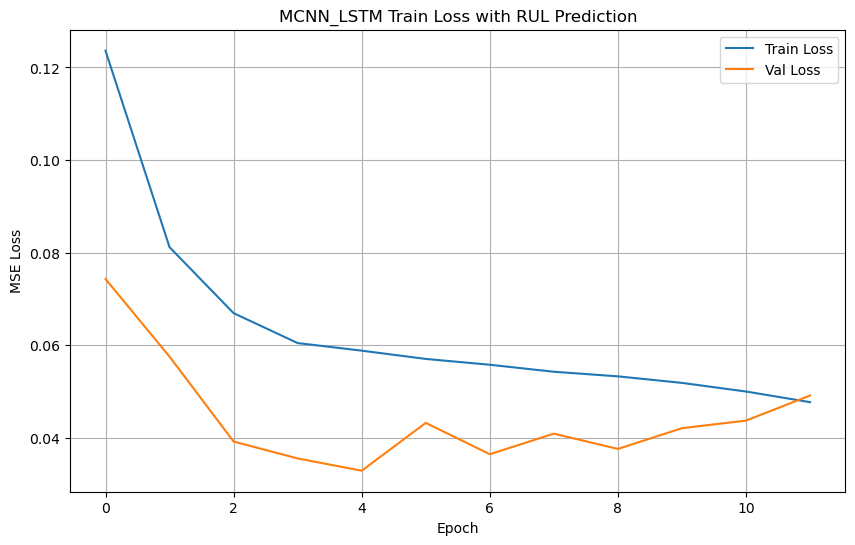

In [ ]:
# --- 결과 시각화 (Optional) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MCNN_LSTM Train Loss with RUL Prediction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

모델 저장

In [ ]:
# Google Drive 내에 저장할 디렉토리 경로
save_path = "MLstudy/KSPHM"
os.makedirs(save_path, exist_ok=True)

# 모델 저장
model.save(os.path.join(save_path, "cnn_lstm_model.h5"))

print("모델이 'cnn_lstm_model.h5'에 성공적으로 저장되었습니다.")

모델이 'cnn_lstm_model.h5'에 성공적으로 저장되었습니다.
